In [2]:
import numpy as np
from tensorflow import keras

# load dataset
# C:\Users\Admin/.keras/datasets/mnist.npz <= saved dataset NMIST

# MNIST: x_train (60000, 28, 28), y_train (60000,) with size img = (28, 28)
#        x_test  (10000, 28, 28), y_test  (10000,) with size img = (28, 28)

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Flatten images: 28*28 = 784 features, convert image to vector 
X_train = x_train.reshape(len(x_train), -1).astype(np.float32)
X_test  = x_test.reshape(len(x_test), -1).astype(np.float32)

print(X_train.shape, y_train.shape)  # (60000, 784) (60000,)
print(X_test.shape, y_test.shape)    # (10000, 784) (10000,)


(60000, 784) (60000,)
(10000, 784) (10000,)


In [3]:
# class distribution: number of each digit in dataset also its ratio, compare to total dataset

counts = np.bincount(y_train, minlength=10)
freq = counts / counts.sum()
for d in range(10):
    print(d, counts[d], freq[d])


0 5923 0.09871666666666666
1 6742 0.11236666666666667
2 5958 0.0993
3 6131 0.10218333333333333
4 5842 0.09736666666666667
5 5421 0.09035
6 5918 0.09863333333333334
7 6265 0.10441666666666667
8 5851 0.09751666666666667
9 5949 0.09915


In [4]:
# overall pixel intensity stat 

print("Train pixel min/max:", X_train.min(), X_train.max())     # check if normalized
print("Train pixel mean/std:", X_train.mean(), X_train.std())   # PCA is variance-based, so scale strongly affects results => check 


Train pixel min/max: 0.0 255.0
Train pixel mean/std: 33.318447 78.567444


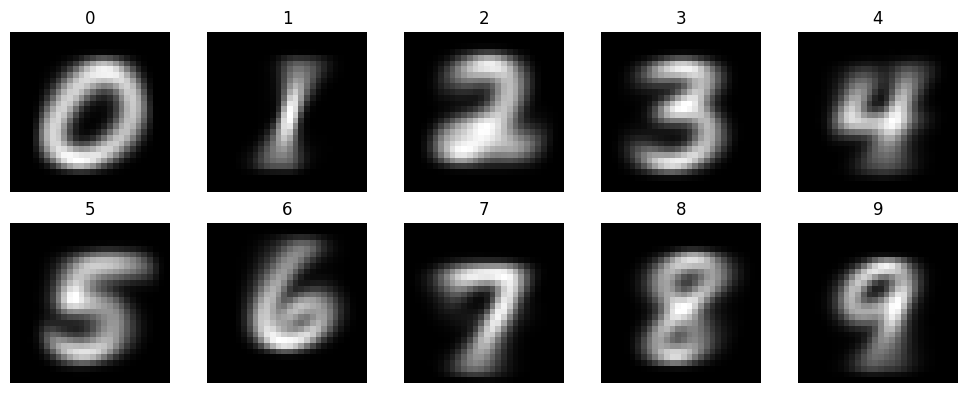

In [5]:
# sanity check 

means = []
for d in range(10):
    class_mean = X_train[y_train == d].mean(axis=0).reshape(28, 28)
    means.append(class_mean)

# visualize
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for d, ax in enumerate(axes.ravel()):
    ax.imshow(means[d], cmap="gray")
    ax.set_title(str(d))
    ax.axis("off")
plt.tight_layout()
plt.show()


In [6]:
# per-feature pixel mean and variance
# result 33.31842 4372.958 => 33.31842/256 and 4372.958/255^2 when normalize
pixel_mean = X_train.mean(axis=0)   # (784,)        # mean intensity cross all img
pixel_var  = X_train.var(axis=0)    # (784,)        # variance intensity cross all iamge
print(pixel_mean.mean(), pixel_var.mean())


33.31842 4372.958


In [7]:
# pca pipeline keep 95% variance, for reduce dimension => training faster, reduce memory and downstream model
# output: need 331 dimensions
#         total explained variance = keep x% of total information of its dimension

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

pca95 = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    # PCA selects the smallest number of components that cumulative explained variance ≥ 0.95
    ("pca", PCA(n_components=0.95, random_state=0))
])

X_train_pca = pca95.fit_transform(X_train)
X_test_pca  = pca95.transform(X_test)

print("Reduced dimension:", X_train_pca.shape[1])
print("Total explained variance:", pca95.named_steps["pca"].explained_variance_ratio_.sum())


Reduced dimension: 331
Total explained variance: 0.95029503


In [8]:
# decide how many component we need (same as above pipeline)

pca_full = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(random_state=0))
])
pca_full.fit(X_train)

evr = pca_full.named_steps["pca"].explained_variance_ratio_
cum = np.cumsum(evr)

# Example: smallest k for 90%, 95%, 99%
for target in [0.90, 0.95, 0.99]:
    k = np.searchsorted(cum, target) + 1
    print(target, k)


0.9 236
0.95 331
0.99 543


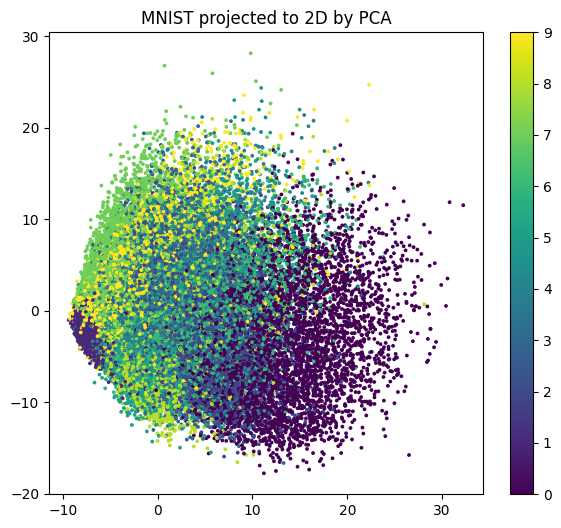

In [9]:
# 2d visualize using PCA 2D
# (1) what each dot is, (2) what the axes mean mathematically, and (3) what conclusions you can and cannot draw

pca2 = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=2, random_state=0))
])
Z = pca2.fit_transform(X_train)

import matplotlib.pyplot as plt
plt.figure(figsize=(7,6))
scatter = plt.scatter(Z[:,0], Z[:,1], c=y_train, s=3)
plt.colorbar(scatter, ticks=range(10))
plt.title("MNIST projected to 2D by PCA")
plt.show()


In [10]:
# test accuracy with number components of PCA

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=100, random_state=0)),
    ("clf", LogisticRegression(max_iter=2000))
])

pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)
print("Test accuracy:", accuracy_score(y_test, pred))


Test accuracy: 0.92


In [11]:
# Clustering (unsupervised): K-Means on PCA features

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

# PCA to something reasonable for clustering (e.g., 50 dims)
pca_for_cluster = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=100, random_state=0))
])

Z_train = pca_for_cluster.fit_transform(X_train)

kmeans = KMeans(n_clusters=10, init="k-means++", n_init="auto", random_state=0)
clusters = kmeans.fit_predict(Z_train)


In [12]:
# Evaluate clustering vs true labels

from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

ari = adjusted_rand_score(y_train, clusters)
nmi = normalized_mutual_info_score(y_train, clusters)
print("ARI:", ari)
print("NMI:", nmi)


ARI: 0.31206078084340155
NMI: 0.4292727769097703


In [13]:
# random forest with all feature (784 features)
# accuracy: 0.9703
# Saved to: D:\ML2-Final\saved_models\mnist_rf_784.joblib

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import joblib
from pathlib import Path

# ===== Train =====
rf = RandomForestClassifier(
    n_estimators=300,
    n_jobs=-1,
    random_state=0
)
rf.fit(X_train, y_train)

# ===== Evaluate =====
pred = rf.predict(X_test)
print("Test accuracy:", accuracy_score(y_test, pred))

# ===== Save =====
save_dir = Path("saved_models")
save_dir.mkdir(parents=True, exist_ok=True)

rf_path = save_dir / "mnist_rf_784.joblib"
joblib.dump(rf, rf_path)
print("Saved to:", rf_path.resolve())

# ===== Load & use later =====
rf_loaded = joblib.load(rf_path)
pred2 = rf_loaded.predict(X_test[:10])
print("Loaded model preds (first 10):", pred2)


Test accuracy: 0.9703
Saved to: D:\ML2-Final\saved_models\mnist_rf_784.joblib
Loaded model preds (first 10): [7 2 1 0 4 1 4 9 5 9]


In [ ]:
# random forest with pca keep x% variances 
# Test accuracy: 0.9377
# Saved to: D:\ML2-Final\saved_models\mnist_pca95_rf.joblib

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import joblib
from pathlib import Path

# ===== Train =====
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=331, random_state=0)),
    ("rf", RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=0))
])

pipe.fit(X_train, y_train)

# ===== Evaluate =====
pred = pipe.predict(X_test)
print("Test accuracy:", accuracy_score(y_test, pred))

# ===== Save =====
save_dir = Path("saved_models")
save_dir.mkdir(parents=True, exist_ok=True)

pipe_path = save_dir / "mnist_pca95_rf.joblib"
joblib.dump(pipe, pipe_path)
print("Saved to:", pipe_path.resolve())

# ===== Load & use later =====
pipe_loaded = joblib.load(pipe_path)
pred2 = pipe_loaded.predict(X_test[:10])
print("Loaded pipeline preds (first 10):", pred2)



Test accuracy: 0.9377
Saved to: D:\ML2-Final\saved_models\mnist_pca95_rf.joblib
Loaded pipeline preds (first 10): [7 2 1 0 4 1 4 9 5 9]


[[ 961    0    4    2    0    3    6    3    1    0]
 [   0 1118    4    1    2    1    5    0    4    0]
 [   9    0  957   19    4    1    8   10   23    1]
 [   0    0   14  942    1    9    2   17   20    5]
 [   1    0    6    2  933    1    6    7    4   22]
 [   9    0    4   42    3  802    9    5   10    8]
 [   8    2    6    1    4   10  924    0    3    0]
 [   0    7   19    6    8    0    0  955    3   30]
 [   7    1    9   28    8   23    7    8  876    7]
 [  10    4    4   17   27    4    0   30    4  909]]


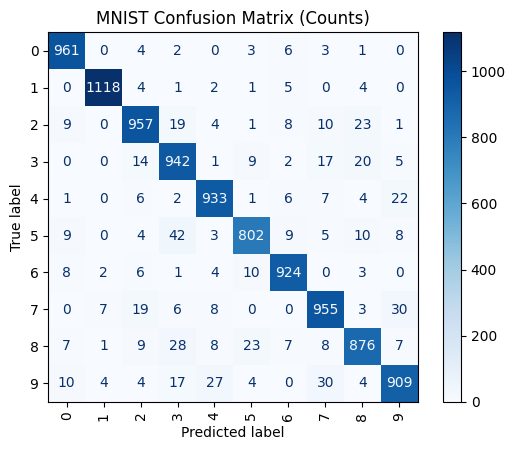

In [ ]:
# confusion metric (not normalized)
# result of mnist_pca95_rf.joblib model

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, pred, labels=range(10))
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap="Blues", xticks_rotation="vertical")
plt.title("MNIST Confusion Matrix (Counts)")
plt.show()

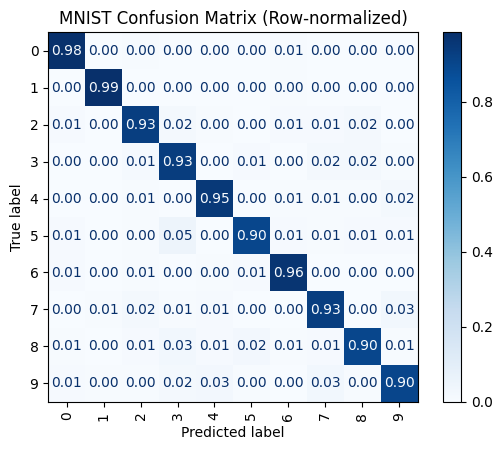

In [17]:
# normalized matrix

cm_norm = confusion_matrix(y_test, pred, labels=range(10), normalize="true")

disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=range(10))
disp.plot(cmap="Blues", values_format=".2f", xticks_rotation="vertical")
plt.title("MNIST Confusion Matrix (Row-normalized)")
plt.show()


In [18]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred, digits=4))


              precision    recall  f1-score   support

           0     0.9562    0.9806    0.9683       980
           1     0.9876    0.9850    0.9863      1135
           2     0.9318    0.9273    0.9296      1032
           3     0.8887    0.9327    0.9101      1010
           4     0.9424    0.9501    0.9462       982
           5     0.9391    0.8991    0.9187       892
           6     0.9555    0.9645    0.9600       958
           7     0.9227    0.9290    0.9258      1028
           8     0.9241    0.8994    0.9116       974
           9     0.9257    0.9009    0.9131      1009

    accuracy                         0.9377     10000
   macro avg     0.9374    0.9369    0.9370     10000
weighted avg     0.9378    0.9377    0.9376     10000

